Este *notebook* representa um pouco do estudo de ciência de dados a partir [deste *dataset*](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) do Kaggle. A maior parte do que aprendi foi baseado na explicação adquirida a partid [deste *notebook*](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python/notebook). Muitos conceitos são explorados neste *notebook*, alguns sendo de estatística, outros de aprendizado de máquina e inteligência artificial. Alguns *insights* também são tirados a partir do meu conhecimento teórico que adquiri na minha graduação de Ciência da Computação.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.preprocessing import StandardScaler

In [2]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [12,6]
sns.set(style="darkgrid")

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

In [3]:
X = pd.read_csv('train.csv')

In [4]:
train_ID = X['Id']

X.drop('Id', axis = 1, inplace = True)

## Funções que serão necessárias durante o código


In [5]:
def unique(list1):
     
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))

    if(all(isinstance(n, not str)) for n in unique_list):
        
        unique_list = [item for item in unique_list if not(pd.isnull(item)) == True]
    
    return unique_list, len(unique_list)

def counterElements(lista):

    auxLista, _ = unique(lista)

    dicio = dict.fromkeys(auxLista, 0)
    dicio['NaN'] = 0

    for i, value in enumerate(auxLista):
        
        counter = 0

        for j in range(len(lista)):

            if lista[j] == auxLista[i]:

                counter += 1
    
        dicio[value] = counter

    dicio['NaN'] = lista.isna().sum()

    return dicio

def createColumnsWNaN(lista):

    totalSum = 0
    columnsWNaN = []

    #keys = X.keys()

    for column in lista:
        
        nullElements = X[column].isnull().sum()

        if(nullElements):
            columnsWNaN.append(column)
            totalSum+=1

    if(totalSum > 1):

        print('There are {} relevant columns in with one or more "NaN" as values: {}'.format(totalSum, columnsWNaN))

    else:
        print('There is 1 relevant column in with one or more "NaN" as values: {}'.format(columnsWNaN))

    return columnsWNaN

def createPercentageOfMissingValues(lista):
    percentColumnWNaN = {}
    totalColumnWNan = {}

    for column in lista:

        if(X[column].isnull().sum() > 0):

            percentColumnWNaN[column] = (X[column].isnull().sum() / len(X[column])) * 100
            totalColumnWNan[column] = X[column].isnull().sum()

    dfPercent = pd.DataFrame(list(percentColumnWNaN.items()), columns = ['Feature', 'Faltantes %'])

    dfPercent['Faltantes Total'] = dfPercent['Feature'].map(totalColumnWNan)

    dfPercent = dfPercent.sort_values(by = ['Faltantes %'], ascending = False)

    return dfPercent

def createHistPlot(feature):

    mean = feature.mean()
    median = feature.median()

    plt.axvline(mean, color = 'r', linestyle = '-')
    plt.axvline(median, color = 'g', linestyle = '-')

    sns.histplot(feature, kde = True)

    print('Assimetria: {}'.format(feature.skew()))

    print('Curtose: {}'.format(feature.kurt()))

    plt.legend({'Média': mean,'Mediana': median})

def createProbPlot(feature):
    stats.probplot(feature, plot=plt)

def removeCatOutliers(column):
    
    dictQual = {key: [] for key in sorted(X[column].unique())}

    indexList = []

    for preco, qualidade in zip(X['SalePrice'], X[column]):

        dictQual[qualidade].append(preco)

    for i in dictQual:

        indexList = np.transpose(np.where(X[column] == i))
        
        arr1 = np.array(dictQual[i])

        # calculando o primeiro quartil (valores 25% menores)
        q1 = np.quantile(arr1, 0.25)
        
        # calculando o terceiro quartil (valores 75% maiores)
        q3 = np.quantile(arr1, 0.75)
        
        # encontrando a região interquartílica
        iqr = q3 - q1
        
        # encontrando os "bigodes", ou variações, de cada feature
        upper_bound = q3+(1.5*iqr)
        lower_bound = q1-(1.5*iqr)

        # encontrando todos os valores que são outliers
        outliers = arr1[(arr1 <= lower_bound) | (arr1 >= upper_bound)]

        indexOutliers = []
        
        #aqui, os outliers são encontrados e removidos do dataset
        if(len(outliers)):

            for i in indexList:
                    
                if(X['SalePrice'].iloc[i[0]] in outliers):

                    indexOutliers.append(i[0])
                
            X.drop(index = indexOutliers, inplace = True)
            X.reset_index(drop=True, inplace=True)


## Informações da saída do dataset 



In [6]:
print(X['SalePrice'].describe())

count     1460.00
mean    180921.20
std      79442.50
min      34900.00
25%     129975.00
50%     163000.00
75%     214000.00
max     755000.00
Name: SalePrice, dtype: float64


Com essas informações, pode-se montar o histograma para a análise dos dados. Algo importante para se ter em conta é que não existe o valor 0 nesse *output*, que atrapalharia o modelo regressor, nada que não pudesse ser tratado, como é explicado em [*Medium, Zero-Inflated Regression*](https://towardsdatascience.com/zero-inflated-regression-c7dfc656d8af).

## Criando um *heatmap* 

Com o *heatmap*, pode-se analisar como as categorias se relacionam. Quanto mais próximo do vermelho, mais a correlação de categorias é diretamente proporcional. De outra forma, as correlações próximas do azul escuro representam catgegorias inversamente proporcionais se relacionando. Correlações próximas do cinza representam como as categorias não se influenciam. A categoria-alvo que o modelo predirá é *SalePrice*, que representa o valor de venda de uma casa.  

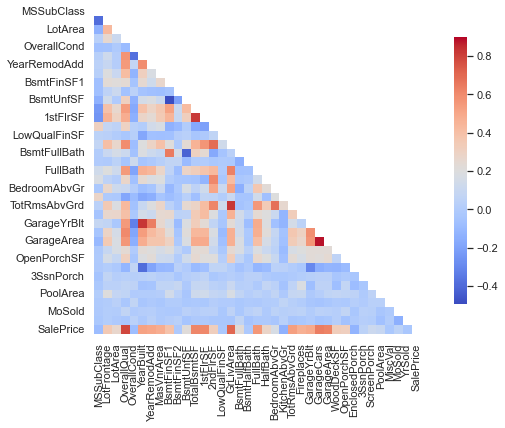

In [7]:
correlation = X.corr()

mask = np.zeros_like(correlation)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):

    f, ax = plt.subplots()

    sns.heatmap(correlation, mask = mask, ax = ax, cbar_kws = {'shrink' : .82},
                vmax = .9, cmap = 'coolwarm', square = True)

## Deletando colunas com valores faltantes

Deve-se deletar o que não for útil para o modelo regressor utilizar para gerar o resultado, e qualquer coluna com mais que 15% de elementos não preenchidos, não é necessário.

In [8]:
columns = X.columns.tolist()

dfPercent = createPercentageOfMissingValues(columns)

print(dfPercent)

         Feature  Faltantes %  Faltantes Total
16        PoolQC        99.52             1453
18   MiscFeature        96.30             1406
1          Alley        93.77             1369
17         Fence        80.75             1179
10   FireplaceQu        47.26              690
0    LotFrontage        17.74              259
11    GarageType         5.55               81
12   GarageYrBlt         5.55               81
13  GarageFinish         5.55               81
14    GarageQual         5.55               81
15    GarageCond         5.55               81
6   BsmtExposure         2.60               38
8   BsmtFinType2         2.60               38
7   BsmtFinType1         2.53               37
5       BsmtCond         2.53               37
4       BsmtQual         2.53               37
3     MasVnrArea         0.55                8
2     MasVnrType         0.55                8
9     Electrical         0.07                1


Agora, deve-se deletar qualquer coluna com mais do que 15% dos elementos não preenchidos.

In [9]:
deletedColumns = []

columns = list(dfPercent['Feature'])

deletedColumns = [dfPercent['Feature'][index] for index, _ in enumerate(columns) if dfPercent['Faltantes %'][index] >= 15]

X.drop(columns = deletedColumns, axis = 1, inplace = True)
X.reset_index(drop=True, inplace=True)

Agora, checa-se os elementos que sobraram após a remoção de colunas.

In [10]:
columns = X.columns.tolist()

dfPercent = createPercentageOfMissingValues(columns)

print(dfPercent)

         Feature  Faltantes %  Faltantes Total
8     GarageType         5.55               81
9    GarageYrBlt         5.55               81
10  GarageFinish         5.55               81
11    GarageQual         5.55               81
12    GarageCond         5.55               81
4   BsmtExposure         2.60               38
6   BsmtFinType2         2.60               38
2       BsmtQual         2.53               37
3       BsmtCond         2.53               37
5   BsmtFinType1         2.53               37
0     MasVnrType         0.55                8
1     MasVnrArea         0.55                8
7     Electrical         0.07                1


Algumas colunas que se relacionam contém a mesma quantidade de valores faltantes, como, por exemplo, as colunas "*Garage*" + alguma coisa, contém exatos 81 elementos valores cada. Talvez, esses valores sejam do mesmo elemento. Melhor confirmar essa afirmação, e, se for verdade, deve-se excluir estes elementos. 

In [11]:
garageColumns = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']

rows = []

[rows.append(X.loc[pd.isna(X[i]), :].index) for i in garageColumns]    

first = rows[0]

[print((np.array(i) == np.array(first)).all()) for i in rows[1:]]
  

True
True
True
True


[None, None, None, None]

As suspeitas se confirmaram: são todos os mesmos elementos. Logo, os mesmos serão excluidos do conjunto de dados.

In [12]:
X.dropna(subset = garageColumns, inplace = True)
X.reset_index(drop=True, inplace=True)

dfPercent = createPercentageOfMissingValues(columns)

print(dfPercent)

        Feature  Faltantes %  Faltantes Total
4  BsmtExposure         2.25               31
6  BsmtFinType2         2.25               31
2      BsmtQual         2.18               30
3      BsmtCond         2.18               30
5  BsmtFinType1         2.18               30
0    MasVnrType         0.58                8
1    MasVnrArea         0.58                8
7    Electrical         0.07                1


A ideia é continuar com as colunas relacionadas e ir eliminando os elementos, caso sejam os mesmos com valores faltantes. Agora, segue-se analisando as colunas "*Bsmt*".

In [13]:
BsmtColumns = ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']

rows = []

[rows.append(X.loc[pd.isna(X[i]), :].index) for i in BsmtColumns]  

[None, None, None, None, None]

Esse tipo de coluna têm uma pequena diferença: As duas primeiras contém um elemento a mais que as últimas três. Checa-se, então, as duas primeiras, depois as três últimas separadamente.

In [14]:
print(f'First comparison: {((np.array(rows[0]) == np.array(rows[1])).all())}')

first = rows[2]

print('Second comparison:')
for i in rows[3:]:
    print((np.array(i) == np.array(first)).all())

First comparison: False
Second comparison:
True
True


As primeiras duas colunas têm elementos diferentes com valores faltantes. Quantos e quais são?

In [15]:
list_difference = [item for item in rows[0] if item not in rows[1]]

print(list_difference)

[897]


O elemento de índice 948 tem a coluna "BsmtExposure" não preenchida, logo, será removido. Não se pode, também, esquecer de remover o índice diferente da lista de valores que foi criada.

In [16]:
X.drop(index = list_difference, inplace = True)
X.reset_index(drop=True, inplace=True)

list(rows[0]).remove(list_difference[0])

Agora, é necessário saber qual elemento está na coluna "BsmtFinType2" mas não em "BsmtExposure".

In [17]:
list_difference = [item for item in rows[1] if item not in rows[0]]

print(list_difference)

[311]


O elemento de índice 332 tem a coluna "BsmtFinType2" não preenchida, logo, será removido. O índice também será removido da lista.

In [18]:
X.drop(index = list_difference, inplace = True)
X.reset_index(drop=True, inplace=True)

list(rows[1]).remove(list_difference[0])

Agora, checa-se se todos os elementos faltantes das colunas do tipo "Bsmt" são os mesmos, agora que são a mesma quantidade de elementos faltantes.

In [19]:
rows = []

[rows.append(X.loc[pd.isna(X[i]), :].index) for i in BsmtColumns]  

[print((np.array(i) == np.array(first)).all()) for i in rows[1:]]

False
False
False
False


[None, None, None, None]

Todos os elementos faltantes são os mesmos. Pode-se, agora, removê-los.

In [20]:
X.dropna(subset = BsmtColumns, inplace = True)
X.reset_index(drop=True, inplace=True)

dfPercent = createPercentageOfMissingValues(columns)

print(dfPercent)

      Feature  Faltantes %  Faltantes Total
0  MasVnrType         0.59                8
1  MasVnrArea         0.59                8
2  Electrical         0.07                1


Falta, agora, remover os elementos das colunas "MasVnr". Checa-se se todos os elementos são os mesmos.

In [21]:
masVnrColumns = ['MasVnrType', 'MasVnrArea']

rows = []

[rows.append(X.loc[pd.isna(X[i]), :].index) for i in masVnrColumns]  

first = rows[0]

[print((np.array(i) == np.array(first)).all()) for i in rows[1:]]

True


[None]

Todos os elementos são iguais, pode-se, então, removê-los.

In [22]:
X.dropna(subset = masVnrColumns, inplace = True)
X.reset_index(drop=True, inplace=True)

dfPercent = createPercentageOfMissingValues(columns)

print(dfPercent)

      Feature  Faltantes %  Faltantes Total
0  Electrical         0.07                1


Sobrou somente 1 elemento faltante, que é um com a coluna "Electrical" não preenchida. Esse elemento será removido.

In [23]:
index = X.loc[pd.isna(X['Electrical']), :].index

X.drop(index = index, inplace = True)
X.reset_index(drop=True, inplace=True)

dfPercent = createPercentageOfMissingValues(columns)

print(dfPercent)

Empty DataFrame
Columns: [Feature, Faltantes %, Faltantes Total]
Index: []


Finalmente, todos os elementos com valores não preenchidos foram removidos.

## Análise de correlações

No *heatmap*, pode-se ver que algumas correlações com *SalePrice* estão em vermelho, indicando que são as categorias mais relevantes para se considerar antes de utilizar o modelo regressor. É, então, selecionado todas as categorias que se correlacionam com *SalePrice* com um valor maior que 0.4.

In [24]:
feature = list(correlation.columns)

values = correlation.values

corrList = []

corrDict = {}

for i, val in enumerate(values[36]):

    if(val > 0.4 and feature[i] != 'SalePrice'):

        corrList.append(feature[i])
        corrDict[feature[i]] = val
        print('SalePrice and {} correlates with value {}.'.format(feature[i], "{:.2f}".format(val)))

print('Total features related to SalePrice: {}'.format(len(corrList)))

SalePrice and OverallQual correlates with value 0.79.
SalePrice and YearBuilt correlates with value 0.52.
SalePrice and YearRemodAdd correlates with value 0.51.
SalePrice and MasVnrArea correlates with value 0.48.
SalePrice and TotalBsmtSF correlates with value 0.61.
SalePrice and 1stFlrSF correlates with value 0.61.
SalePrice and GrLivArea correlates with value 0.71.
SalePrice and FullBath correlates with value 0.56.
SalePrice and TotRmsAbvGrd correlates with value 0.53.
SalePrice and Fireplaces correlates with value 0.47.
SalePrice and GarageYrBlt correlates with value 0.49.
SalePrice and GarageCars correlates with value 0.64.
SalePrice and GarageArea correlates with value 0.62.
Total features related to SalePrice: 13


In [25]:
updatedCorrelation = corrList

updatedCorrelation.append('SalePrice')

Com as correlações, pode-se ver melhor a forma em que cada categoria se relaciona com *SalePrice*. 

<function matplotlib.pyplot.show(close=None, block=None)>

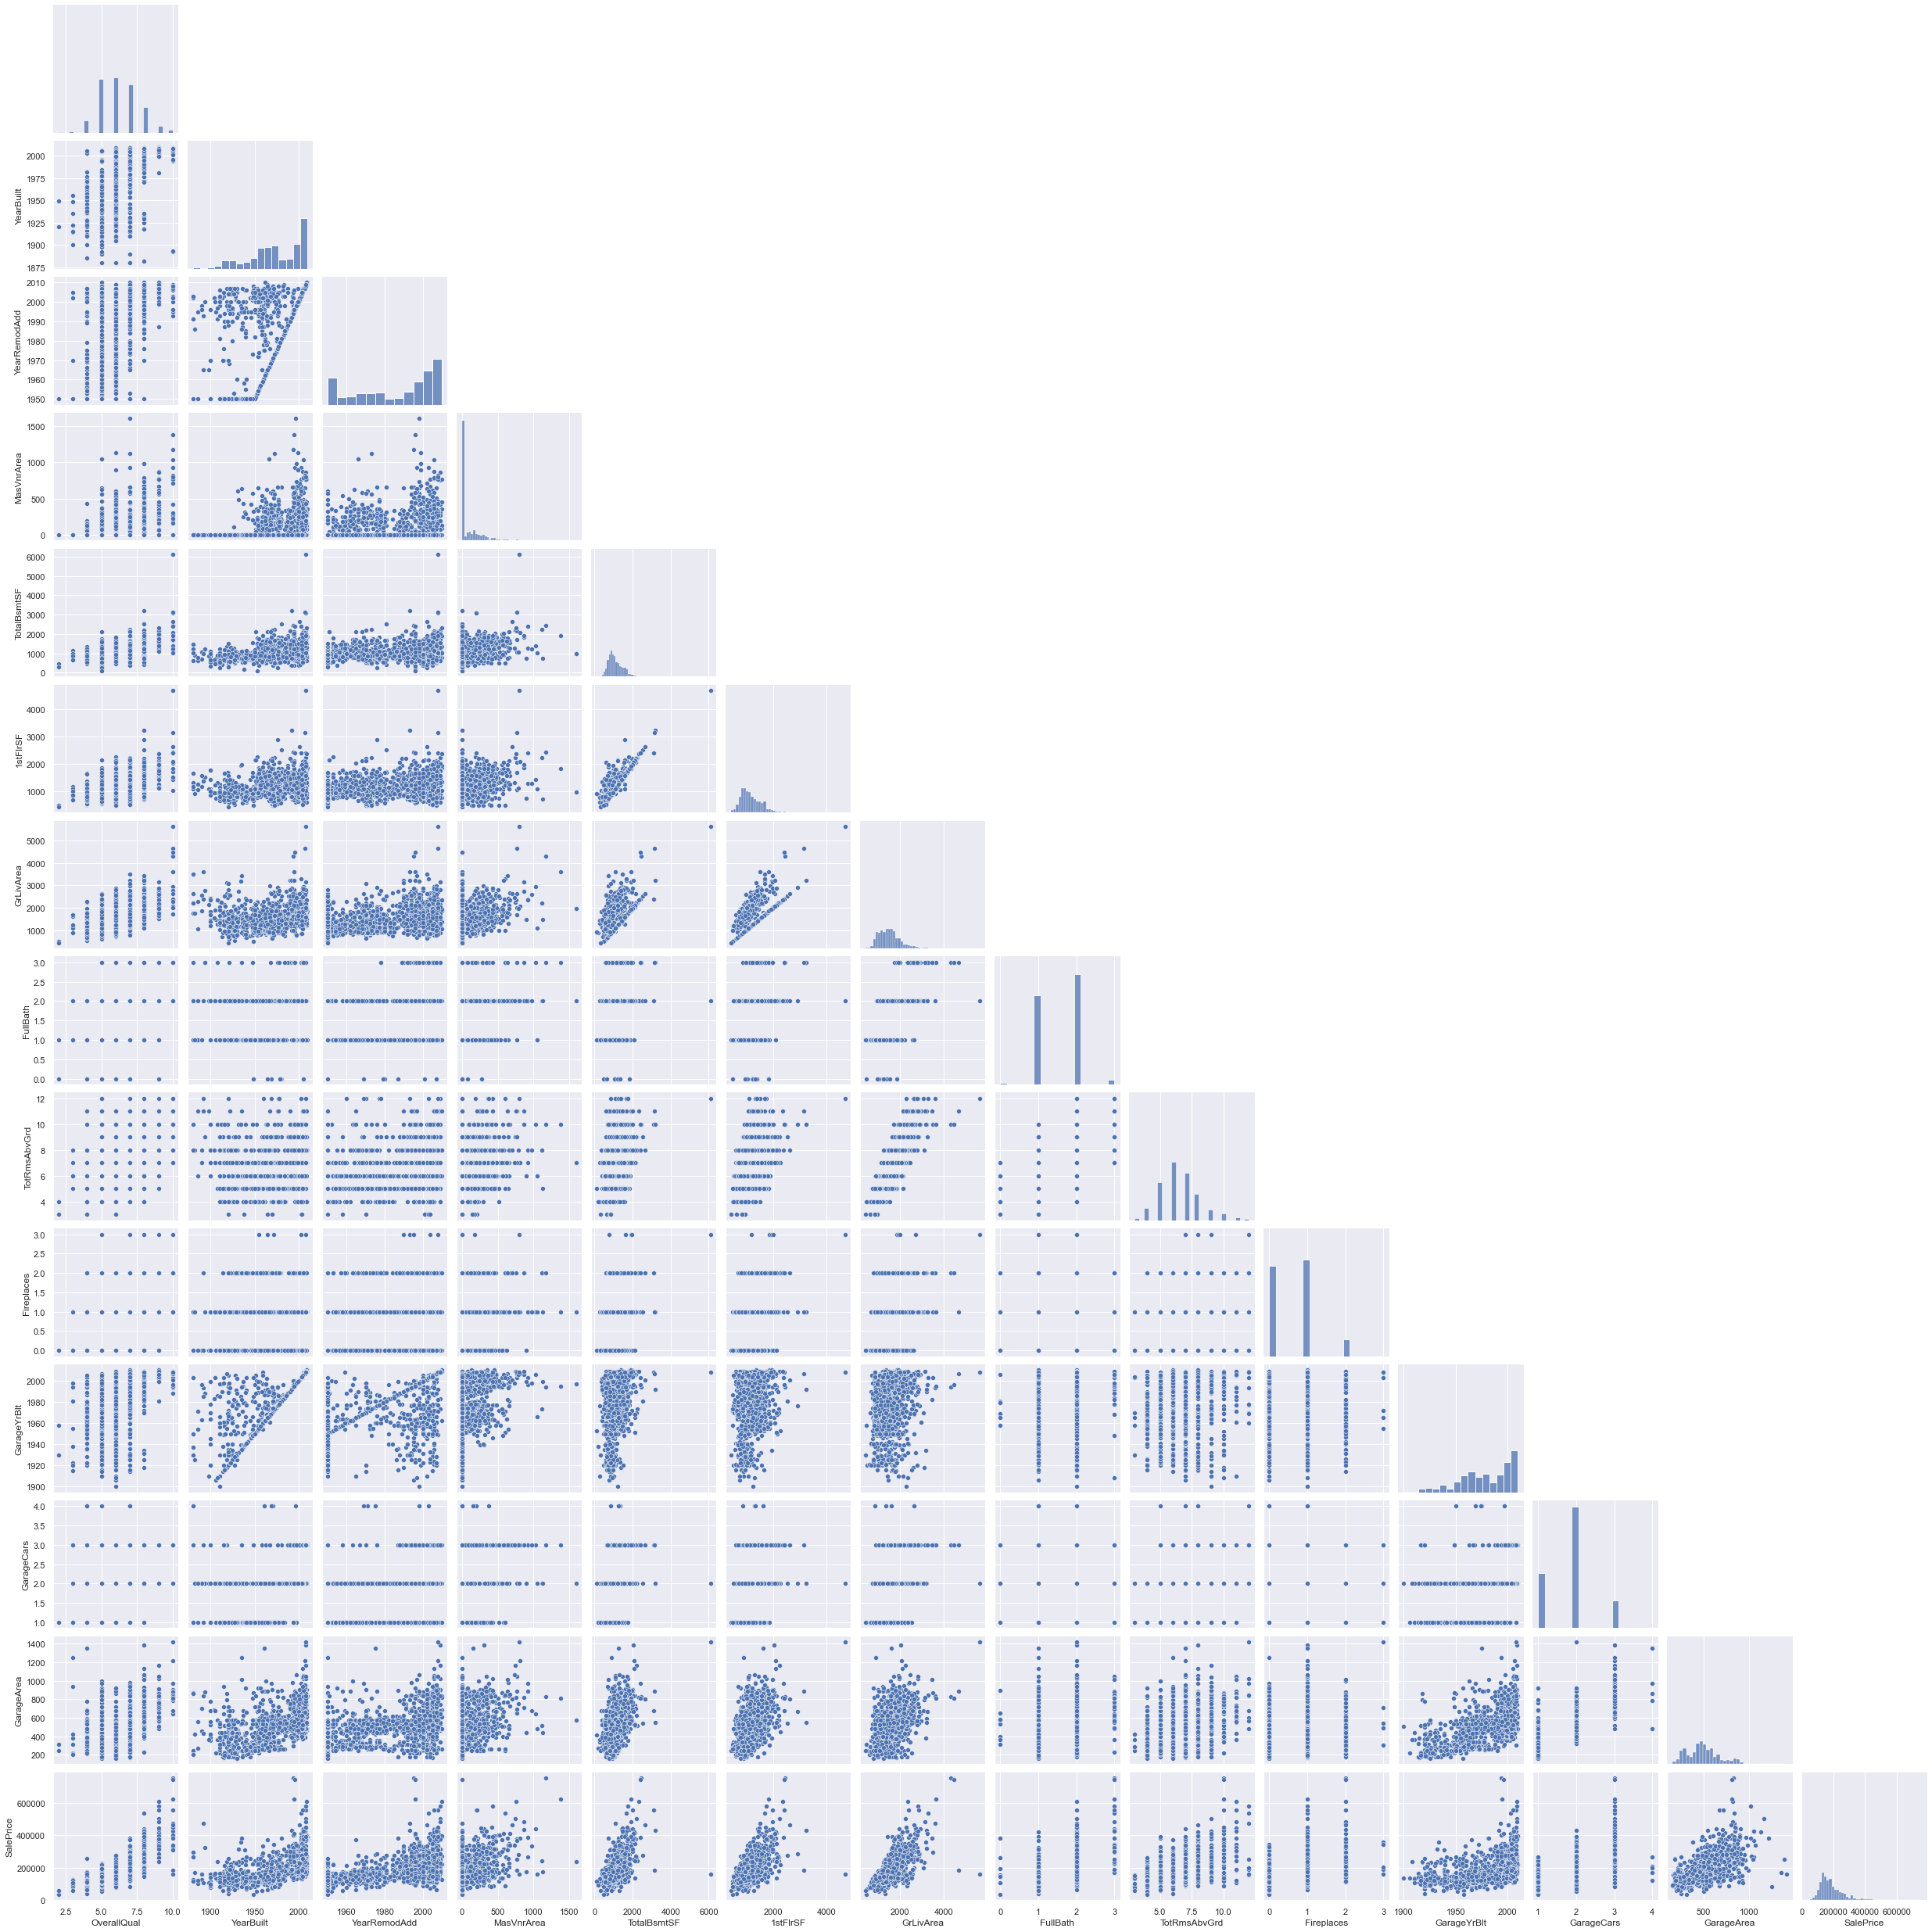

In [26]:
sns.set()

sns.pairplot(X[updatedCorrelation], height = 2.5, corner = True)

plt.show

Algumas categorias são interessantes de analisar: *1stFlrSF* se relaciona com *SalePrice* formando algo como uma exponencial, indicando que, quanto maior a área do primeiro andar, mais caro uma casa pode ser vendida, crescendo de maneira abrupta a partir de um valor. *GrLivArea* e *TotalBsmtSF* se comportam de maneira parecida. 

Já *YearBuilt*, *YearRemodAdd*, *GarageYrBlt* e *GarageArea* se comportam de maneira similar à uma fórmula linear, mantendo um crescimento constante em relação ao aumento do preço da casa. 

As *features* categóricas (*OverallQual*, *FullBath*, *TotRmsAbvGrd*, *Fireplaces* e *GarageCars*) tem um crescimento mais linear.

## Procurando por *outliers*

Baseando-se na análise feita dos gráficos relacionados à categoria *SalePrice* e a forma como os dados são exibidos entre si, pode-se analisar o quanto cada elemento do conjunto de dados é relevante para a construção do modelo regressor. 



### Análise univariada
Antes de analisarmos os dados comparando com *SalePrice*, um bom caminho a seguir é primeiro padronizar os dados desta coluna. Padronizando os dados, a média tende a 0, com um desvio padrão esperado de 1 (ou seja, variando entre -1 e 1).

In [27]:
saleprice_scaled = StandardScaler().fit_transform(np.array(X['SalePrice'])[:,np.newaxis])

low_range  = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]

print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.91990905]
 [-1.8604676 ]
 [-1.65772778]
 [-1.62594708]
 [-1.6069319 ]
 [-1.6069319 ]
 [-1.57672312]
 [-1.54988636]
 [-1.52453279]
 [-1.5181944 ]]

outer range (high) of the distribution:
[[3.78070184]
 [3.99414088]
 [4.45257146]
 [4.66807681]
 [4.68811881]
 [5.02217745]
 [5.38630543]
 [5.55545178]
 [7.07666601]
 [7.20343387]]


Valores em "low_range" indicam os primeiros 10 valores, sendo estes não tão longe de 0, indicando que não existem muitos valores como *outliers* menores que a média.

Valores em "high_range" são os 10 últimos em *SalePrice*, que variam até 7 ou mais, indicando uma **grande** variação. 

Agora, analisaremos os gráficos das *features* correlacionadas à *SalePrice*.


### Análise bivariada

#### Começando com os gráficos de *features* numéricas e analisado sua distribuição em relação à *SalePrice*.

Para criar os gráficos, as categorias numéricas serão ordenadas em relação à correlação com *SalePrice*. 

In [28]:
numFeatures = ['GrLivArea', 'YearBuilt', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GarageYrBlt', 'GarageArea']

numValues = [corrDict[key] for key in numFeatures]

numValues.sort(reverse = True)

sortedNumFeatures = [key for key in sorted(corrDict, key = corrDict.get, reverse = True) if key in numFeatures]

for i in range(len(numFeatures)):
    print(f'{sortedNumFeatures[i]}: {"{:.2}".format(numValues[i])}')

GrLivArea: 0.71
GarageArea: 0.62
TotalBsmtSF: 0.61
1stFlrSF: 0.61
YearBuilt: 0.52
GarageYrBlt: 0.49
MasVnrArea: 0.48


##### *Feature*: "GrLivArea"

1338


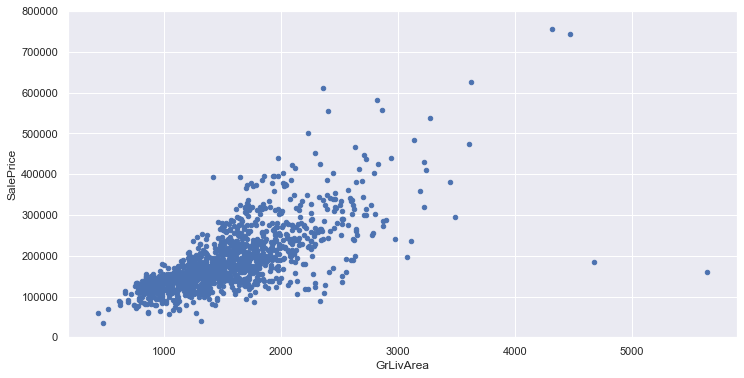

In [29]:
X.plot.scatter(x = 'GrLivArea', y = 'SalePrice', color = '#4C72B0', ylim=(0,800000))

print(X.shape[0])

A representação dos elementos mais acima (com *SalePrice* > 700.000) são os elementos com a variação > 7. Estes elementos seguem o padrão que outros elementos representam, algo como uma função linear.

Já os elementos mais a esquerda (com *GrLivArea* >= 4500) são elementos considerados *outliers*, sendo assim, removê-los é beneficial para o modelo regressor ter uma precisão maior.

In [30]:
outliers = []

outliers = [index for index, value in enumerate(X['GrLivArea']) if value >= 4500]

X.drop(outliers, inplace = True)

Após esta remoção de elementos, os próximos gráficos se mantém dentro de um padrão, sem muitos *outliers*.

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

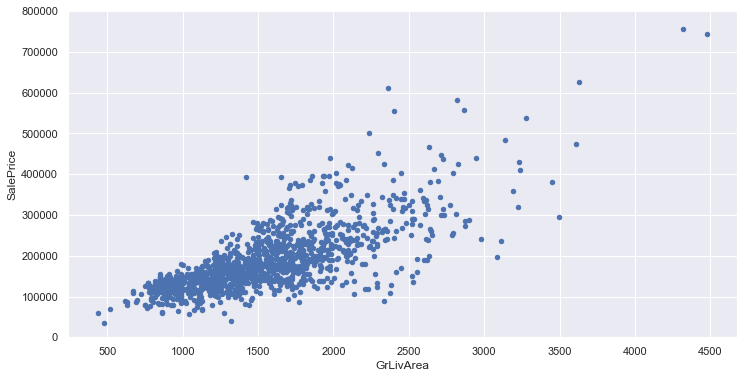

In [31]:
X.plot.scatter(x = 'GrLivArea', y = 'SalePrice', color = '#4C72B0', ylim=(0,800000))

A partir dessa remoção, as outras *features* não apresentam mais *outliers*.

##### *Feature*: "1stFlrSF"

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

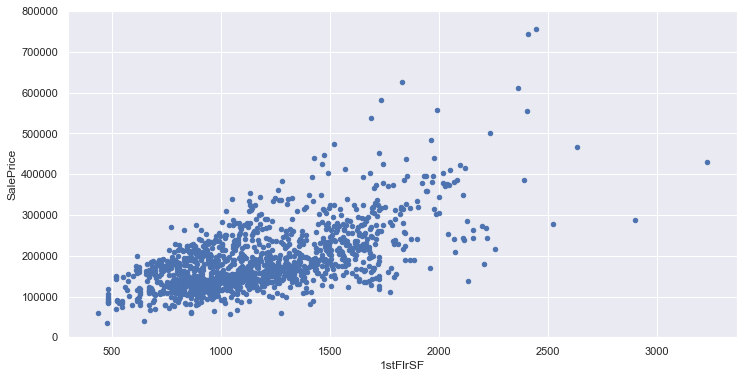

In [32]:
X.plot.scatter(x = '1stFlrSF', y = 'SalePrice', color = '#4C72B0', ylim=(0,800000))

##### *Feature*: "YearBuilt"

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

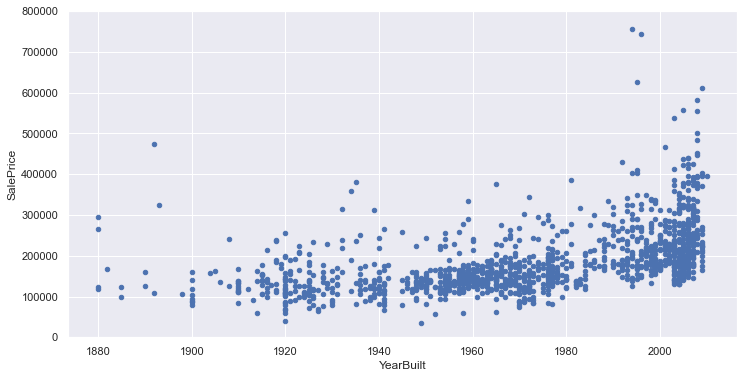

In [33]:
X.plot.scatter(x = 'YearBuilt', y = 'SalePrice', color = '#4C72B0', ylim=(0,800000))

##### *Feature*: "GarageYrBlt"


<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

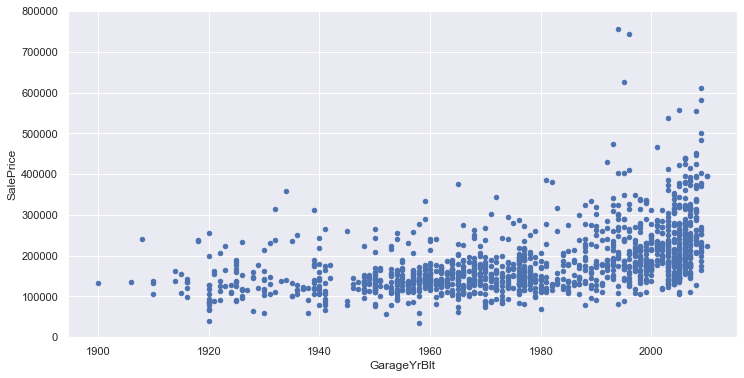

In [34]:
X.plot.scatter(x = 'GarageYrBlt', y = 'SalePrice', color = '#4C72B0', ylim=(0,800000))

##### *Feature*: "MasVnrArea"

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

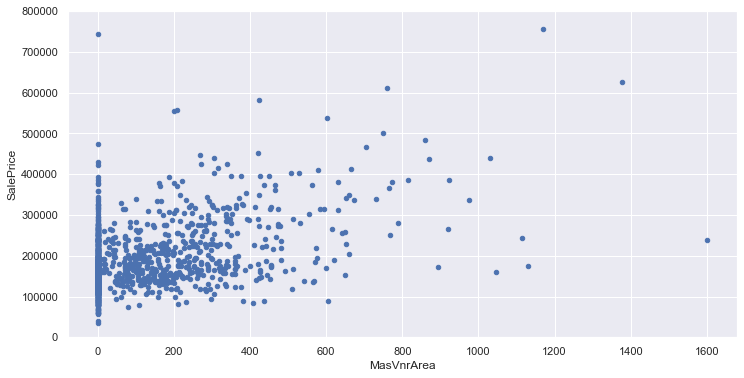

In [35]:
X.plot.scatter(x = 'MasVnrArea', y = 'SalePrice', color = '#4C72B0', ylim=(0,800000))

#### Continuando com os gráficos de *features* categóricas.

In [36]:
catFeatures = ['OverallQual', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces']

catValues = [corrDict[key] for key in catFeatures]

catValues.sort(reverse = True)

sortedCatFeatures = [key for key in sorted(corrDict, key = corrDict.get, reverse = True) if key in catFeatures]

for i in range(len(catFeatures)):
    print(f'{sortedCatFeatures[i]}: {"{:.2}".format(catValues[i])}')

OverallQual: 0.79
FullBath: 0.56
TotRmsAbvGrd: 0.53
Fireplaces: 0.47


Com o diagrama de caixa, podemos ver melhor as *features* categóricas e seus *outliers* de maneira mais clara. Em cada *feature*, pode-se ver que praticamente todas têm um ou mais *outliers*. Para melhorar a precisão do regressor, deve-se analisar caso a caso, a fim de decidir entre removê-los, se fugirem muito do padrão, ou mantê-los, caso sigam a ideia do conjunto de dados.

##### *Feature*: "OverallQual"

(-0.5, 8.5, 0.0, 800000.0)

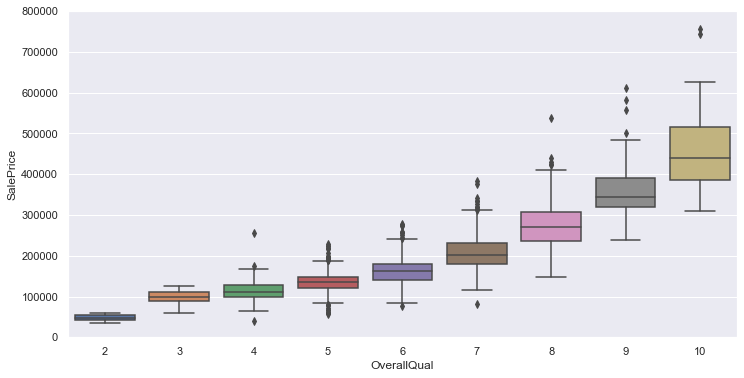

In [37]:
data = pd.concat([X['SalePrice'], X['OverallQual']], axis = 1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

Os diamantes em preto representam os *outliers*. Infelizmente, a biblioteca Seaborn não disponibiliza os elementos *outliers*, mas é possível calculá-los manualmente para a remoção.

In [38]:
removeCatOutliers('OverallQual')

Agora, checa-se como está a distribuição da *feature*, com os *outliers removidos*.

(-0.5, 8.5, 0.0, 800000.0)

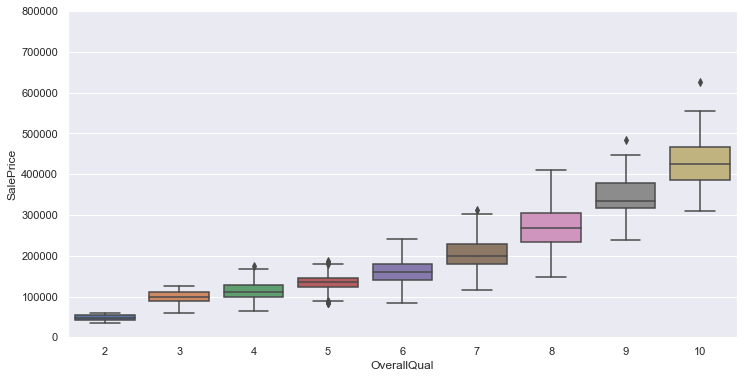

In [39]:
data = pd.concat([X['SalePrice'], X['OverallQual']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

Com os *outliers* removidos, alguns valores em ambos os limites inferiores e superiores viraram *outliers*, mas estes não serão removidos.

##### *Feature*: "FullBath" 

(-0.5, 3.5, 0.0, 800000.0)

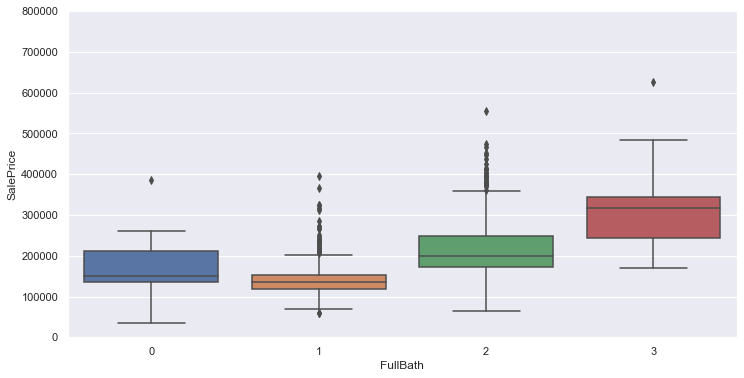

In [40]:
data = pd.concat([X['SalePrice'], X['FullBath']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'FullBath', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

In [41]:
removeCatOutliers('FullBath')

(-0.5, 3.5, 0.0, 800000.0)

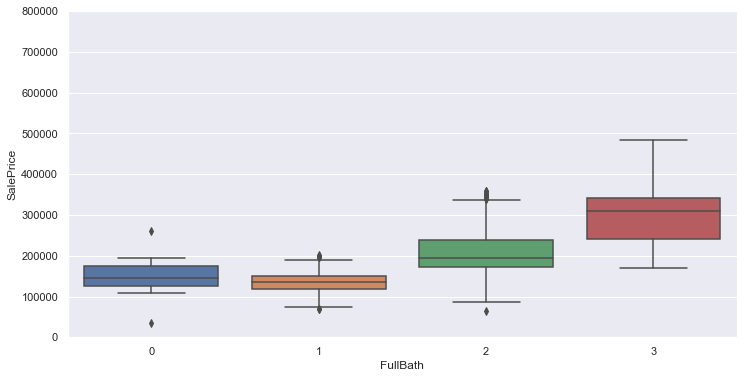

In [42]:
data = pd.concat([X['SalePrice'], X['FullBath']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'FullBath', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

##### *Feature* = "TotRmsAbvGrd"

(-0.5, 9.5, 0.0, 800000.0)

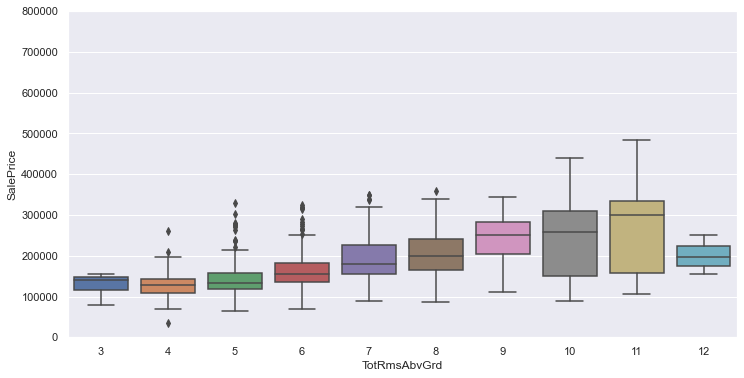

In [43]:
data = pd.concat([X['SalePrice'], X['TotRmsAbvGrd']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'TotRmsAbvGrd', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

In [44]:
removeCatOutliers('TotRmsAbvGrd')

(-0.5, 9.5, 0.0, 800000.0)

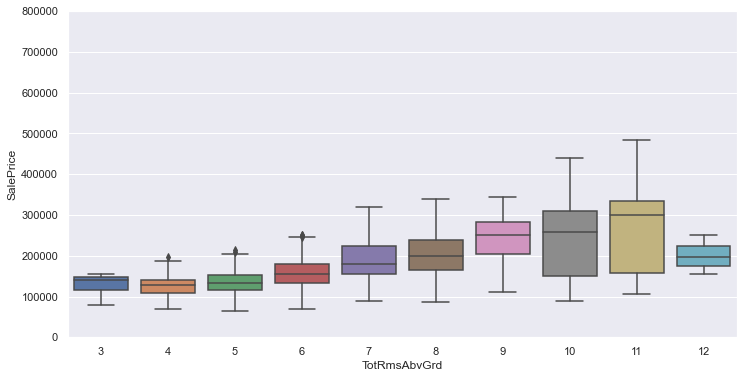

In [45]:
data = pd.concat([X['SalePrice'], X['TotRmsAbvGrd']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'TotRmsAbvGrd', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

##### *Feature* = "Fireplaces"

(-0.5, 3.5, 0.0, 800000.0)

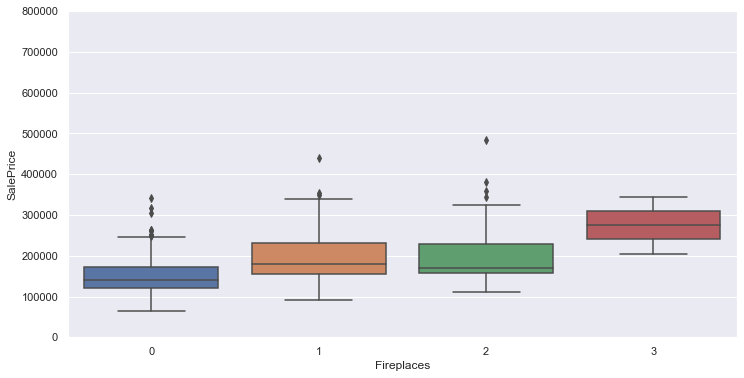

In [46]:
data = pd.concat([X['SalePrice'], X['Fireplaces']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'Fireplaces', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

In [47]:
removeCatOutliers('Fireplaces')

(-0.5, 3.5, 0.0, 800000.0)

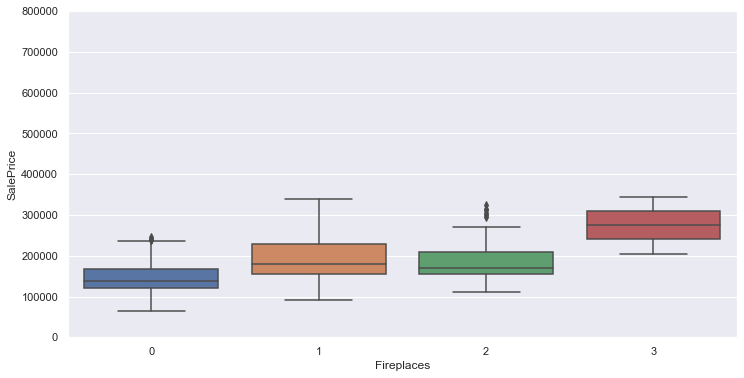

In [48]:
data = pd.concat([X['SalePrice'], X['Fireplaces']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'Fireplaces', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

#### Após todas essas remoções de *outliers*, quantos elementos no conjunto de dados ainda existem?

In [49]:
print(f'Existem {X.shape[0]} elementos no conjunto de dados.')

Existem 1167 elementos no conjunto de dados.


## Análise mais detalhada das *features*


Com o histograma e o gráfico de probabilidade dos dados gerado, é possível analisar melhor o formato das *features*. 

### *Feature*: *GrLivArea*


Assimetria: 0.730099231604454
Curtose: 0.5929128544966651


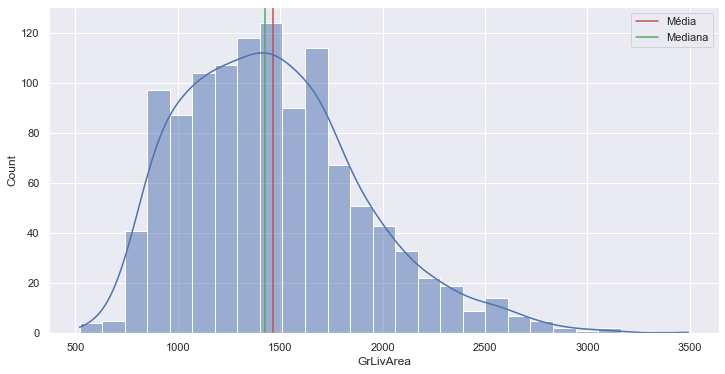

In [50]:
createHistPlot(X['GrLivArea'])

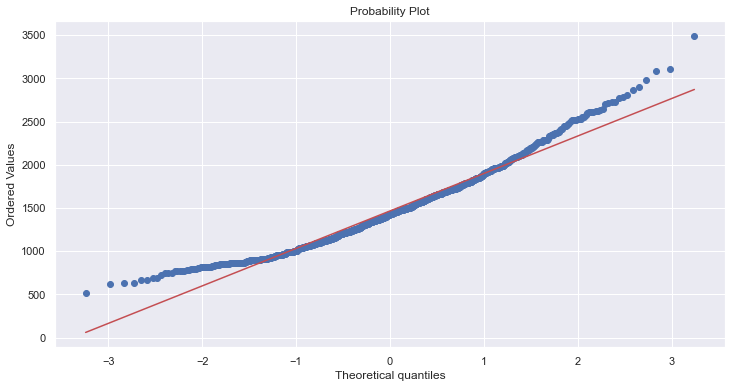

In [51]:
createProbPlot(X['GrLivArea'])

Dado que a assimetria e a curtose são diferente de zero, é aplicado a transformação nos dados.

In [52]:
normGrLivArea = np.log(X['GrLivArea'])

Assimetria: -0.0339848985281265
Curtose: -0.3665840109424874


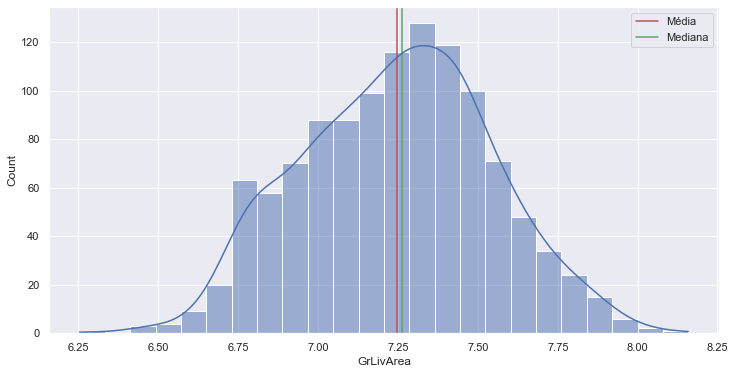

In [53]:
createHistPlot(normGrLivArea)

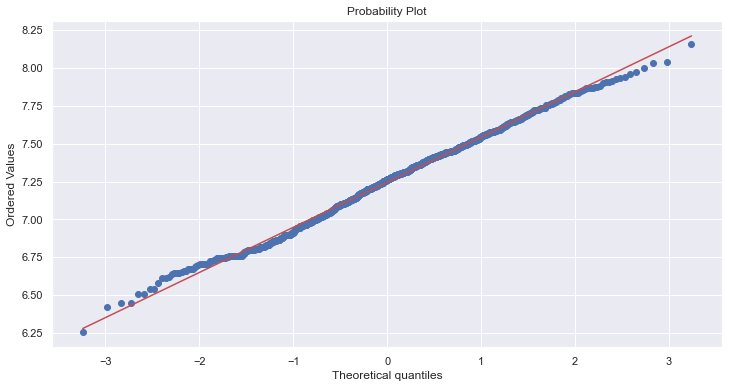

In [54]:
createProbPlot(normGrLivArea)

Os novos valores, além dos gráficos, são bem melhores que antes da transformação.

In [55]:
X['GrLivArea'] = normGrLivArea

### *Feature*: *GarageArea*

Assimetria: 0.7775176995798992
Curtose: 1.3302893197523913


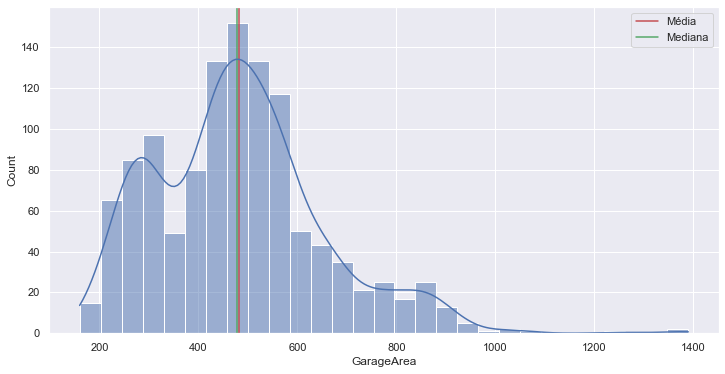

In [56]:
createHistPlot(X['GarageArea'])

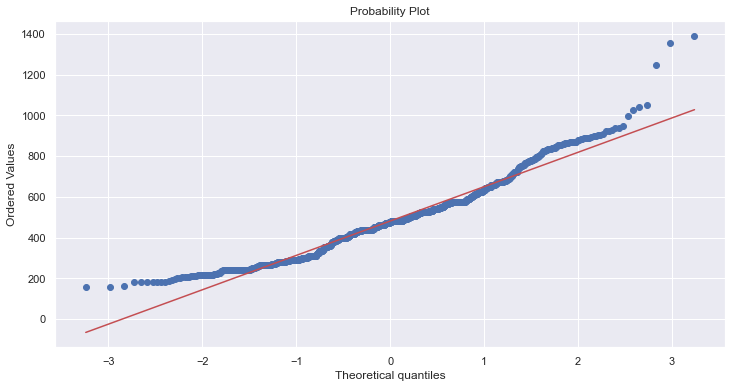

In [57]:
createProbPlot(X['GarageArea'])

A assimetria e a curtose estão relativamente próximas de 0, mas o gráfico de probabilidade nos indica que é possível melhorar.

In [58]:
normGarageArea = np.log(X['GarageArea'])

Assimetria: -0.26578613567459913
Curtose: -0.2504752766903784


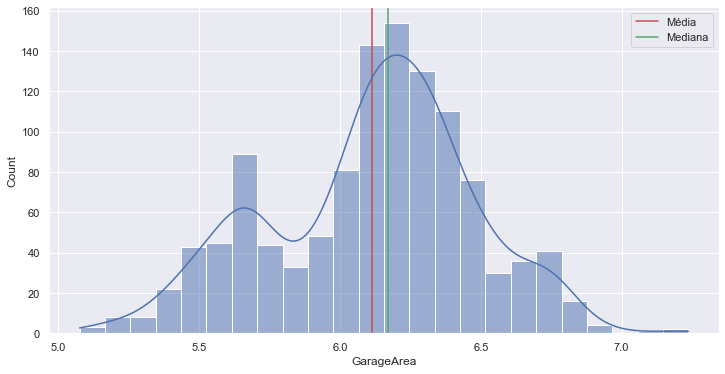

In [59]:
createHistPlot(normGarageArea)

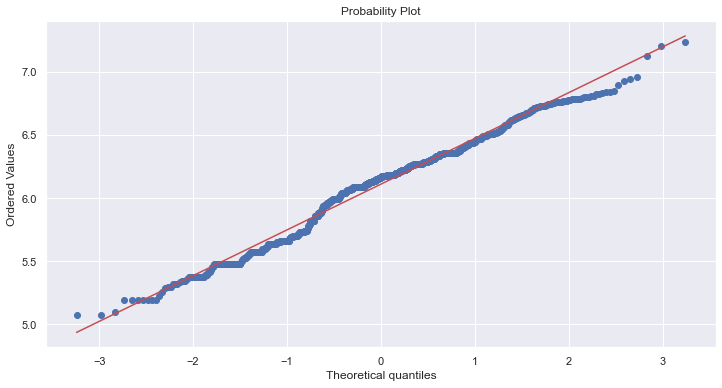

In [60]:
createProbPlot(normGarageArea)

Uma melhora significativa nos valores, apesar do histograma não ter mais semelhança com a distribuição normal.

In [61]:
X['GarageArea'] = normGarageArea

### *Feature*: *TotalBsmtSF*

Assimetria: 0.7081156138363798
Curtose: 0.5832641759713599


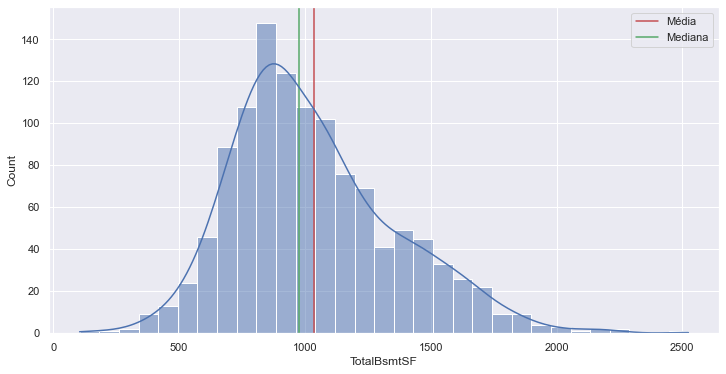

In [62]:
createHistPlot(X['TotalBsmtSF'])

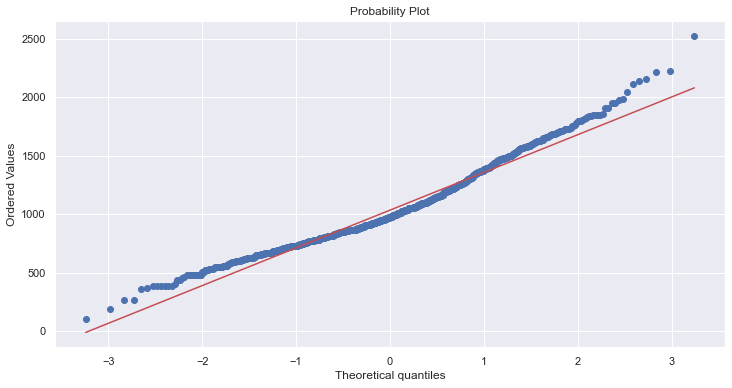

In [63]:
createProbPlot(X['TotalBsmtSF'])

A assimetria e a curtose apresentam valores relativamente próximos de 0, e a distribuição no gráfico de probabilidade lembra uma linha reta, logo, sem configurações necessárias. 

In [64]:
normTotalBsmtSF = np.log(X['TotalBsmtSF'])

Assimetria: -0.5481260436830493
Curtose: 2.4830103211213954


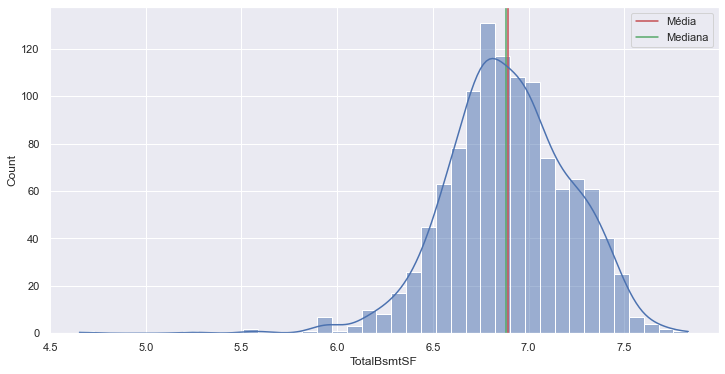

In [65]:
createHistPlot(normTotalBsmtSF)

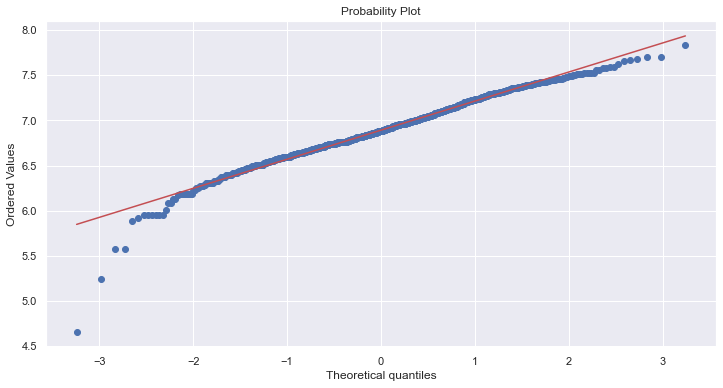

In [66]:
createProbPlot(normTotalBsmtSF)

A normalização, nesse caso, atrapalhou mais do que ajudou, logo, a *feature* manterá o valor original.

### *Feature*: *1stFlrSF*

Assimetria: 0.8508757293573719
Curtose: 1.0595810806285755


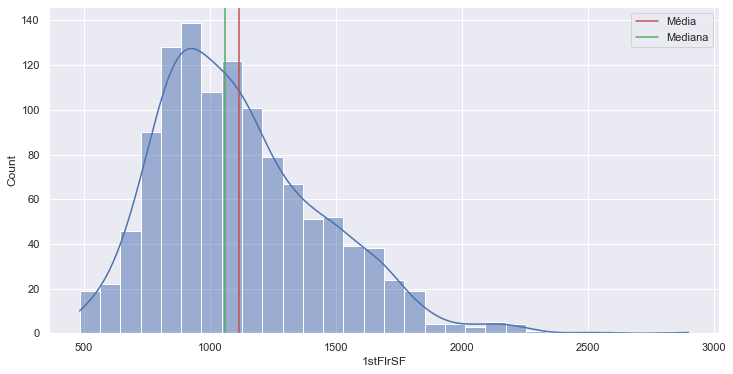

In [67]:
createHistPlot(X['1stFlrSF'])

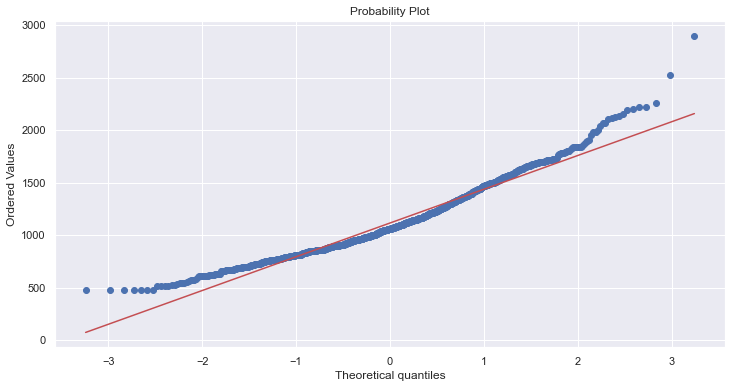

In [68]:
createProbPlot(X['1stFlrSF'])

Com a assimetria e a curtose levemente se distanciando de 0, aplica-se a transformação, em busca de uma melhora.

In [69]:
norm1stFlrSF = np.log(X['1stFlrSF'])

Assimetria: 0.03096419564552061
Curtose: -0.12438502921214267


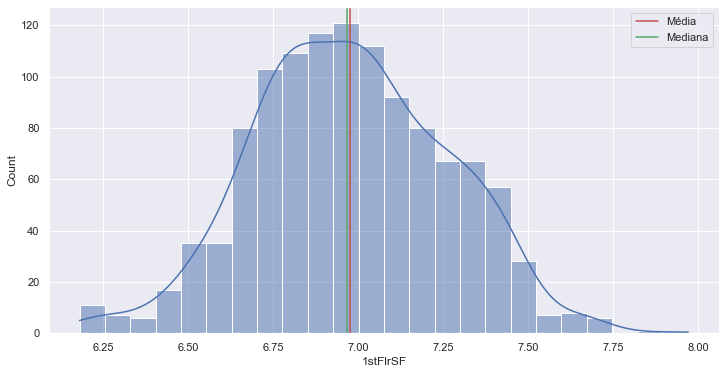

In [70]:
createHistPlot(norm1stFlrSF)

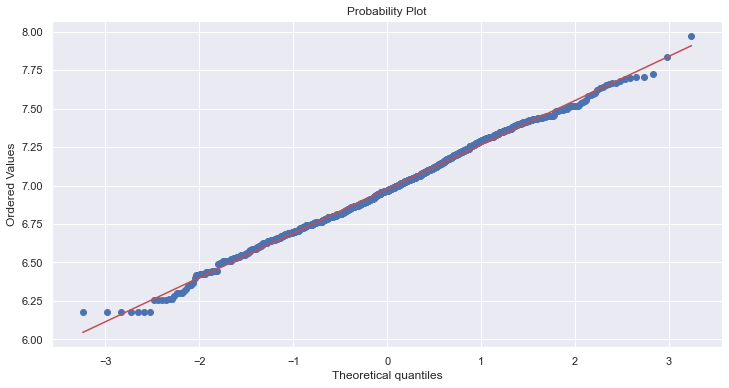

In [71]:
createProbPlot(norm1stFlrSF)

Uma boa melhora em relação à assimetria, curtose e os gráficos.

In [72]:
X['1stFlrSF'] = norm1stFlrSF

### *Feature*: *YearBuilt*

Assimetria: -0.6311194182757853
Curtose: -0.3461923590363094


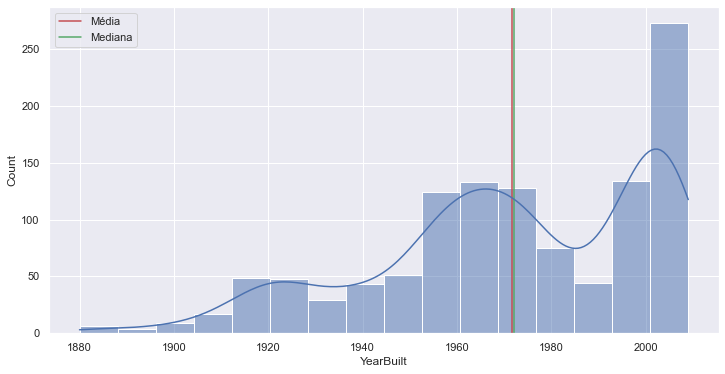

In [73]:
createHistPlot(X['YearBuilt'])

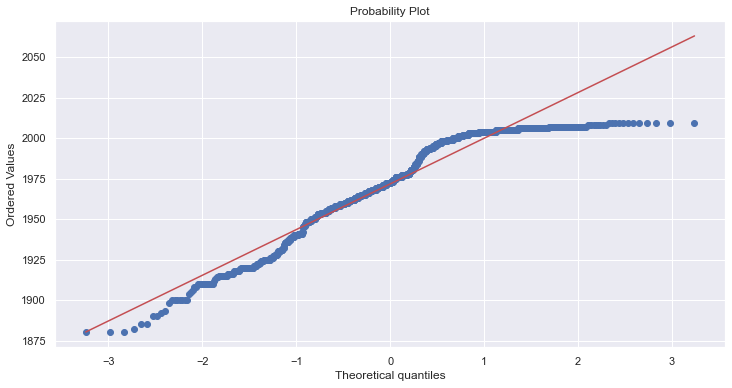

In [74]:
createProbPlot(X['YearBuilt'])

Apesar da aparência do gráfico, a assimetria e a curtose estão relativamente próximas do ideal valor 0, indicando que, talvez, realizar a transformação dos dados não traga um ganho. 

### *Feature*: *GarageYrBlt*

Assimetria: -0.6305760603850539
Curtose: -0.3776723177561312


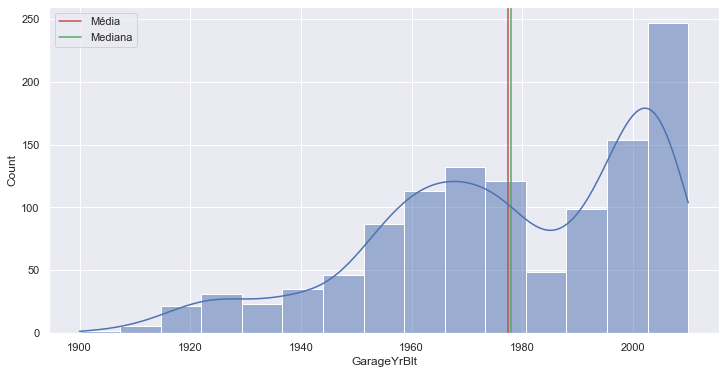

In [75]:
createHistPlot(X['GarageYrBlt'])

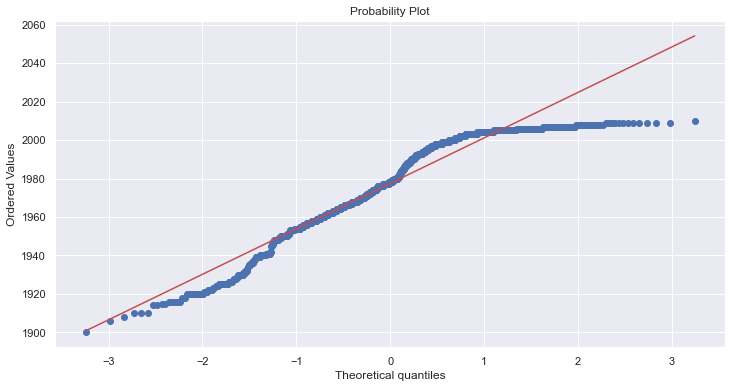

In [76]:
createProbPlot(X['GarageYrBlt'])

Assim como a *feature YearBuilt*, *GarageYrBlt* não tem uma assimetria e curtose longe de 0, e, com uma transformação, o resultado não deve melhorar.

### *Feature*: *MasVnrArea*

Assimetria: 2.871581554304202
Curtose: 13.543621394013332


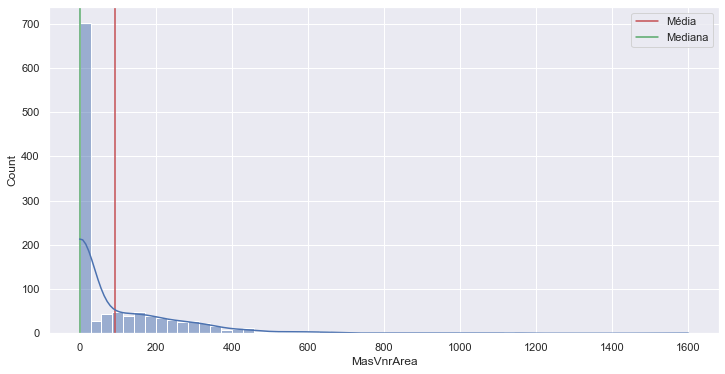

In [77]:
createHistPlot(X['MasVnrArea'])

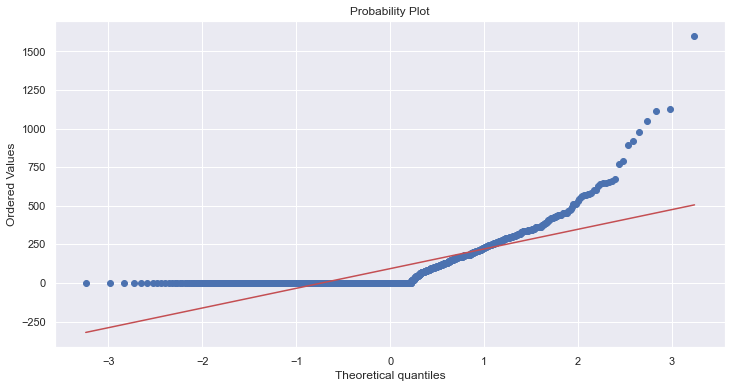

In [78]:
createProbPlot(X['MasVnrArea'])

Dado a grande ocorrência de 0 nessa *feature*, tentar transformar para melhorar a distribuição não vai melhorar o resultado.

## Por fim, é gerado as variáveis *dummy*

In [79]:
X = pd.get_dummies(X)

In [ ]:
print(X.shape)

## Agora, finalmente, os dados estão prontos para serem utilizados por um algoritmo regressor.